In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import urllib.request
import csv
import re
import string
import emoji
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Read Datasets
Read data from github (https://github.com/cardiffnlp/tweeteval/tree/main/datasets/emotion)

In [ ]:
#Read Datasets
url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt"

with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    test_labels = pd.DataFrame(html, columns=['data'])


url= "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt"

with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    test_text = pd.DataFrame(html, columns=['data'])


url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt"


with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    train_labels = pd.DataFrame(html, columns=['data'])


url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt"

with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    train_text = pd.DataFrame(html, columns=['data'])




url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt"


with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    val_labels = pd.DataFrame(html, columns=['data'])


url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt"

with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    html = [line for line in html if line.strip()]  # Remove empty lines
    val_text = pd.DataFrame(html, columns=['data'])


url = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt"

with urllib.request.urlopen(url) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
mapping = [row[1] for row in csvreader if len(row) > 1]
mapping = pd.DataFrame(mapping, columns=['data'])




### Preprocess Text

In [ ]:
#Preprosessing

from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

exclude = string.punctuation

#some tweets include text that seems like unreadable emojjis (e.g. :rolling_on_the_floor_laughing:). Exclude them
exclude_structure= r":(?!:)[^:]+:"

def preprocess(row):
    # lowercasing
    row = row.lower()
    # delete urls
    re_html = re.compile('https?://\S+|www\.\S+')
    row = re_html.sub(r'', row)
    # remove punctiation
    row=row.translate(str.maketrans('', '', exclude))
    #remove emojis
    row=emoji.demojize(row)
    # exclude unreadable emojis :some_text:
    row=re.sub(exclude_structure, "", row)

    return row


#Preprocess the data
test_text.data=test_text.data.apply(preprocess)
train_text.data=train_text.data.apply(preprocess)
val_text.data=val_text.data.apply(preprocess)


In [ ]:
from nltk.corpus import stopwords

#Remove Stopwords
stopwords_english = stopwords.words('english')

def split_tweets(row):
  new_text=[]
  row=row.split(' ')
  for word in row:
    if word in stopwords_english or word=="":
      continue
    else:
      new_text.append(word)
  row=new_text
  return row


test_text.data=test_text.data.apply(split_tweets)
train_text.data=train_text.data.apply(split_tweets)
val_text.data=val_text.data.apply(split_tweets)



In [ ]:
# Select data to keep, build unique vocabulary, make numeric
data=[]
for row in test_text.data:
  data.append(row)

for row in train_text.data:
  data.append(row)

for row in val_text.data:
  data.append(row)

#get unique words
unique_words = set()

for item in data:
    words = item
    unique_words.update(words)

vocab = unique_words
vocab_size = len(vocab)


#function to get index from word
word_to_ix = {word: i for i, word in enumerate(vocab)}


#keep anger and joy & tokenize - testset
labels_to_keep=['0','1']


X_test, y_test = [], []
for i in test_text.index:
  X_test.append(test_text.loc[i,'data'])
  y_test.append(test_labels.loc[i,'data'])

X_numeric_test=[]
for i in X_test:
  X_numeric_test.append([word_to_ix[w] for w in i])

df_test=pd.DataFrame(columns=['X','y'])
df_test.X=X_numeric_test
df_test.y=y_test

df_test=df_test[df_test.y.isin(labels_to_keep)].reset_index(drop=True)


#Keep anger & joy and tokenize - training set
X_train, y_train = [], []
for i in train_text.index:
  X_train.append(train_text.loc[i,'data'])
  y_train.append(train_labels.loc[i,'data'])

X_numeric_train=[]
for i in X_train:
  X_numeric_train.append([word_to_ix[w] for w in i])


df_train=pd.DataFrame(columns=['X','y'])
df_train.X=X_numeric_train
df_train.y=y_train

df_train=df_train[df_train.y.isin(labels_to_keep)].reset_index(drop=True)


#Keep anger & joy and tokenize - validation set
X_val, y_val = [], []
for i in val_text.index:
  X_val.append(val_text.loc[i,'data'])
  y_val.append(val_labels.loc[i,'data'])

X_numeric_val=[]
for i in X_val:
  X_numeric_val.append([word_to_ix[w] for w in i])


df_val=pd.DataFrame(columns=['X','y'])
df_val.X=X_numeric_val
df_val.y=y_val

df_val=df_val[df_val.y.isin(labels_to_keep)].reset_index(drop=True)




# Get max no. words per tweet for padding
max_len=[]
max_len.append(df_train['X'].apply(len).max())


max_len.append(df_test['X'].apply(len).max())


max_len.append(df_test['X'].apply(len).max())

max_length=max(max_len)
print(f"maximum number of words per tweet is {max_length}")



maximum number of words per tweet is 24


In [ ]:
#Pad all tweets with zeroes at the end to match the longest tweet in dataset (24 words)
for i in df_test.index:
  while len(df_test.loc[i, 'X']) < max_length:
    df_test.loc[i, 'X'].append(0)

for i in df_train.index:
  while len(df_train.loc[i, 'X']) < max_length:
    df_train.loc[i, 'X'].append(0)


for i in df_val.index:
  while len(df_val.loc[i, 'X']) < max_length:
    df_val.loc[i, 'X'].append(0)

# Data Loader


In [ ]:
#Load data to DataLoader

from torch.utils.data import IterableDataset, DataLoader

num_batches=20

X_train=torch.FloatTensor(df_train.X.to_list())

y_train=torch.FloatTensor(df_train.y.astype(float).to_list())

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#Load data to dataloader
class MyDataset(IterableDataset):
    def __init__(self, data_X, data_y):
        assert len(data_X) == len(data_y)
        self.data_X = data_X.to(device)
        self.data_y = data_y.to(device)

    def __len__(self):
        return len(self.data_X)

    def __iter__(self):
        for i in range(len(self.data_X)):
            yield (self.data_X[i], self.data_y[i])

train_set = MyDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=num_batches)




X_val=torch.FloatTensor(df_val.X.to_list())

y_val=torch.FloatTensor(df_val.y.astype(float).to_list())



val_set = MyDataset(X_val, y_val)
val_loader = DataLoader(val_set, batch_size=num_batches)



# load test set
X_test=torch.FloatTensor(df_test.X.to_list())

y_test=torch.FloatTensor(df_test.y.astype(float).to_list())


test_set = MyDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=num_batches)

# Initial Run

CNN class strucutre adapted from: https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f

Batch Size: 20

Output Activation: Sigmoid

Hidden Layer Activation: ReLU

Embedding Size: 50

Dropout: 0.2

Loss Function: BCE Loss

Learning Rate: 0.05

Optimizer: Adadelta

Convolution Layers:
- layer1: kernel size 2

- layer2: kernel size 3

- layer3: kernel size 4


Pooling: each poold with MaxPool1D with stride 1

In [ ]:
class CNN(nn.Module):

   def __init__(self):
        super(CNN, self).__init__()

        self.seq_len = max_length
        self.num_words = vocab_size
        self.embedding_size = 100

        self.dropout = nn.Dropout(0.2)


        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4


        self.stride = 1

        # Output size for each convolution
        self.out_size = 30

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)



         # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)



        # output layers sized (see here: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
        # simplifies for each conv layer to: embedding_size-(kernel_size-1) since stride=1, padding=0, dillation=1
        #factor 2 in front of second term is due to convolution and padding
        self.output_size=self.out_size*(3*self.embedding_size - 2*(self.kernel_1 + self.kernel_2 + self.kernel_3  - 3))
        self.linear = nn.Linear(self.output_size, 1)

        self.output_activation=nn.Sigmoid()
        self.nonlin=nn.ReLU()





   def forward(self, x):

        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        #print(x1.shape)
        x1 = self.nonlin(x1)
        #print(x1[0])
        x1 = self.pool_1(x1)
        #print(x1[0])
        #print('--------------------------')

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = self.nonlin((x2))
        x2 = self.pool_2(x2)


        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = self.nonlin(x3)
        x3 = self.pool_3(x3)



        #print(x1.shape, x2.shape, x3.shape, x4.shape)


        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3), 2)
        #print(union.shape)
        union = union.reshape(union.size(0), -1)
        #print(union.shape)
        #print(self.output_size)

        # The "flattened" vector is passed through a fully connected layer
        out = self.linear(union).float()
        # Dropout is applied
        out = self.dropout(out)
        # Activation function is applied
        out = self.output_activation(out)

        return out.squeeze()

In [ ]:
losses = []
loss_function = nn.BCELoss()
# Instantiate Adadelta optimizer
model = CNN()
optimizer = optim.Adadelta(model.parameters(),
                               lr=0.05,
                               rho=0.95)
model.to(device)
num_epochs=40



for epoch in range(num_epochs):
    total_loss = 0
    counter=0
    for batch in train_loader:
        counter=counter+1

        X=batch[0]
        y=batch[1]
        counter=counter+1


        # Prepare input vector
        context_idxs = torch.tensor(X, dtype=torch.long).to(device)

        # zero out gradients
        model.zero_grad()

        # run forward pass
        log_probs = model(context_idxs)

        # Compute loss function
        loss = loss_function(log_probs, torch.tensor(y, dtype=torch.float).to(device))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()


        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)

    if (epoch+1)%10==0:
      print(f'Epoch [{epoch+1}/{num_epochs}], loss: {total_loss}]')

<ipython-input-86-74712ed6292d>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context_idxs = torch.tensor(X, dtype=torch.long).to(device)
<ipython-input-86-74712ed6292d>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(log_probs, torch.tensor(y, dtype=torch.float).to(device))


Epoch [10/40], loss: 52.4411016702652]
Epoch [20/40], loss: 39.238435834646225]
Epoch [30/40], loss: 30.382140204310417]
Epoch [40/40], loss: 24.971852265298367]


In [ ]:
import numpy as np
# Set the model in evaluation mode
model.eval()
predictions = []

# Start evaluation phase
with torch.no_grad():
  for batch in val_loader:
    X = batch[0]
    y = batch[1]
    y_pred = model(X.to(torch.int64))
    predictions += list(y_pred.cpu().numpy())

# Convert 'predictions' to a numpy array
predictions = np.array(predictions)



from sklearn.metrics import accuracy_score, f1_score

# Convert y_true to float
y_true = df_val['y'].astype(float)

# Calculate accuracy
accuracy = accuracy_score(y_true, predictions.round())

# Calculate F1 score
f1 = f1_score(y_true, predictions.round(), average='macro')

print(f"Accurancy on Validation Dataset: {accuracy}")

print(f"F1-score on Validation Dataset: {f1}")

Accurancy on Validation Dataset: 0.6381322957198443
F1-score on Validation Dataset: 0.5187556629417095


In [ ]:
import numpy as np
# Set the model in evaluation mode
model.eval()
predictions = []

# Start evaluation phase
with torch.no_grad():
  for batch in test_loader:
    X = batch[0]
    y = batch[1]
    y_pred = model(X.to(torch.int64))
    predictions += list(y_pred.cpu().numpy())

# Convert 'predictions' to a numpy array
predictions = np.array(predictions)



from sklearn.metrics import accuracy_score, f1_score

# Convert y_true to float
y_true = df_test['y'].astype(float)

# Calculate accuracy
accuracy = accuracy_score(y_true, predictions.round())

# Calculate F1 score
f1 = f1_score(y_true, predictions.round(), average='macro')

print(f"Accurancy on Test Dataset: {accuracy}")

print(f"F1-score on Test Dataset: {f1}")

Accurancy on Test Dataset: 0.6222707423580786
F1-score on Test Dataset: 0.5396797731920431


In [ ]:
import numpy as np
# Set the model in evaluation mode
model.eval()
predictions = []

# Start evaluation phase
with torch.no_grad():
  for batch in train_loader:
    X = batch[0]
    y = batch[1]
    y_pred = model(X.to(torch.int64))
    predictions += list(y_pred.cpu().numpy())

# Convert 'predictions' to a numpy array
predictions = np.array(predictions)



from sklearn.metrics import accuracy_score, f1_score

# Convert y_true to float
y_true = df_train['y'].astype(float)

# Calculate accuracy
accuracy = accuracy_score(y_true, predictions.round())

# Calculate F1 score
f1 = f1_score(y_true, predictions.round(), average='macro')

print(f"Accurancy on Training Dataset: {accuracy}")

print(f"F1-score on Training Dataset: {f1}")


Accurancy on Training Dataset: 0.9781783681214421
F1-score on Training Dataset: 0.9751301609122291


# Hyperparameter tuning

Pooling: each poold with MaxPool1D with **stride=2**.
Additionally, we introduce **weight decay** (L2 regularization) to avoid overfitting.

Hyperparameter tuning for **learning rate, dropout probability, embedding size, and number of filters.**

For each hyperparameter we test test 4-5 options and letting each option run 4 times to increase the robustness of our findings.

In [ ]:
import math
class CNN(nn.Module):

   def __init__(self,dropout, embedding_size, out_size):
        super(CNN, self).__init__()

        self.seq_len = max_length
        self.num_words = vocab_size
        self.embedding_size = embedding_size

        self.dropout = nn.Dropout(dropout)


        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4



        self.stride = 1

        # Output size for each convolution
        self.out_size = out_size

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0, max_norm=5.0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)



         # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, 2)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, 2)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, 2)



        # output layers sized (see here: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
        # simplifies for each conv layer to: embedding_size-(kernel_size-1) since stride=1, padding=0, dillation=1
        #factor 2 in front of second term is due to convolution and padding
        self.output_size=int(0.5*self.out_size*(3*self.embedding_size - 2*(self.kernel_1 + self.kernel_2 + self.kernel_3  - 3)))

        # Batch Norm
        self.batch_norm = nn.BatchNorm1d(self.output_size)

        self.linear = nn.Linear(self.output_size, 1)

        self.output_activation=nn.Sigmoid()
        self.nonlin=nn.ReLU()





   def forward(self, x):


        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        #print(x1.shape)
        x1 = self.nonlin(x1)
        #print(x1[0])
        x1 = self.pool_1(x1)
        x1=self.dropout(x1)
        #print(x1[0])
        #print('--------------------------')

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = self.nonlin((x2))
        x2 = self.pool_2(x2)
        x2 = self.dropout(x2)


        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = self.nonlin(x3)
        x3 = self.pool_3(x3)
        x3 = self.dropout(x3)



        #print(x1.shape, x2.shape, x3.shape, x4.shape)


        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3), 2)
        #print(union.shape)
        union = union.reshape(union.size(0), -1)
        #print(union.shape)
        #print(self.output_size)

        norm=self.batch_norm(union)

        # The "flattened" vector is passed through a fully connected layer
        out = self.linear(norm).float()
        # Dropout is applied
        out = self.dropout(out)
        # Activation function is applied
        out = self.output_activation(out)

        return out.squeeze()

In [ ]:
eval_dict={}
for learning_rate in [0.1, 0.2, 0.3, 0.4, 0.5]:
  iteration_list=[]
  for iteration in range(1, 5):
    patience = 10  # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
    best_loss = float('inf')  # Initialize the best validation loss
    wait = 0  # Counter for patience


    losses = []
    loss_function = nn.BCELoss()
    #loss_function = nn.CrossEntropyLoss()
    # Instantiate Adadelta optimizer
    model = CNN(0.3,100,30)
    optimizer = optim.Adadelta(model.parameters(),
                                  lr=learning_rate,
                                  weight_decay=10e-3,
                                  rho=0.99)

    model.to(device)
    num_epochs=60


    for epoch in range(num_epochs):
        total_loss = 0
        counter = 0

        for batch in train_loader:
          total_loss = 0
        counter=0
        for batch in train_loader:
            counter=counter+1

            X=batch[0]
            y=batch[1]
            counter=counter+1


            # Prepare input vector
            context_idxs = torch.as_tensor(X, dtype=torch.long, device=device)

            # zero out gradients
            model.zero_grad()

            # run forward pass
            log_probs = model(context_idxs)

            # Compute loss function
            loss = loss_function(log_probs, torch.as_tensor(y, dtype=torch.float, device=device))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()


            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()



        losses.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {total_loss}]')

        # Validation loss calculation (assuming you have a validation_loader)
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_batch in val_loader:
                val_X, val_y = val_batch
                val_context_idxs = torch.as_tensor(val_X, dtype=torch.long, device=device)
                val_log_probs = model(val_context_idxs)
                val_loss += loss_function(val_log_probs, torch.as_tensor(val_y, dtype=torch.float, device=device)).item()
            val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
            break


    import numpy as np
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Start evaluation phase
    with torch.no_grad():
      for batch in test_loader:
        X = batch[0]
        y = batch[1]
        y_pred = model(X.to(torch.int64))
        predictions += list(y_pred.cpu().numpy())

    # Convert 'predictions' to a numpy array
    predictions = np.array(predictions)



    from sklearn.metrics import accuracy_score, f1_score

    # Convert y_true to float
    y_true = df_test['y'].astype(float)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, predictions.round())

    # Calculate F1 score
    f1 = f1_score(y_true, predictions.round(), average='macro')

    print(f"Learning Rate: {learning_rate}")

    print(f"Accurancy on Test Dataset: {accuracy}")

    print(f"F1-score on Test Dataset: {f1}")

    iteration_list.append(f1)
  eval_dict[learning_rate]=iteration_list

Epoch [10/60], loss: 41.31191225349903]
Epoch [20/60], loss: 45.79166907072067]
Epoch [30/60], loss: 24.896007485687733]
Epoch [40/60], loss: 6.030266689136624]
Early stopping after 41 epochs with no improvement in validation loss.
Learning Rate: 0.1
Accurancy on Test Dataset: 0.7631004366812227
F1-score on Test Dataset: 0.733994248220468
Epoch [10/60], loss: 40.64598794281483]
Epoch [20/60], loss: 46.977655708789825]
Epoch [30/60], loss: 27.069160640239716]
Epoch [40/60], loss: 5.336174763739109]
Epoch [50/60], loss: 2.9044411992654204]
Epoch [60/60], loss: 2.2533142869360745]
Learning Rate: 0.1
Accurancy on Test Dataset: 0.769650655021834
F1-score on Test Dataset: 0.7437932062966032
Epoch [10/60], loss: 41.67071780562401]
Epoch [20/60], loss: 46.09242558479309]
Epoch [30/60], loss: 23.382903829216957]
Early stopping after 38 epochs with no improvement in validation loss.
Learning Rate: 0.1
Accurancy on Test Dataset: 0.730349344978166
F1-score on Test Dataset: 0.6920597718608408
Epoch

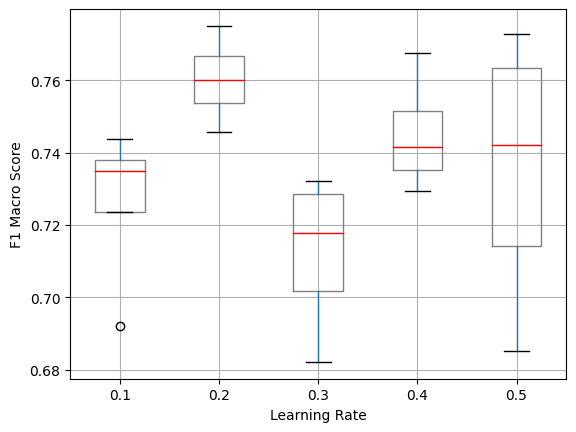

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'eval_dict'
# with columns 'Learning Rate' and 'F1 Macro Score'

# Create a boxplot from the DataFrame
boxplot = pd.DataFrame.from_dict(eval_dict).boxplot(color=dict(boxes='gray', medians='red'))

# Set the x-axis label
plt.xlabel("Learning Rate")

# Set the y-axis label
plt.ylabel("F1 Macro Score")

# Display the plot
plt.show()

In [ ]:
eval_dict={}
for dropout in [0.1, 0.2, 0.3, 0.4, 0.5]:
  iteration_list=[]
  for iteration in range(1, 5):
    patience = 10  # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
    best_loss = float('inf')  # Initialize the best validation loss
    wait = 0  # Counter for patience


    losses = []
    loss_function = nn.BCELoss()
    #loss_function = nn.CrossEntropyLoss()
    # Instantiate Adadelta optimizer
    model = CNN(dropout,100,30)
    optimizer = optim.Adadelta(model.parameters(),
                                  lr=0.2,
                                  weight_decay=10e-3,
                                  rho=0.99)

    model.to(device)
    num_epochs=60


    for epoch in range(num_epochs):
        total_loss = 0
        counter = 0

        for batch in train_loader:
          total_loss = 0
        counter=0
        for batch in train_loader:
            counter=counter+1

            X=batch[0]
            y=batch[1]
            counter=counter+1


            # Prepare input vector
            context_idxs = torch.as_tensor(X, dtype=torch.long, device=device)

            # zero out gradients
            model.zero_grad()

            # run forward pass
            log_probs = model(context_idxs)

            # Compute loss function
            loss = loss_function(log_probs, torch.as_tensor(y, dtype=torch.float, device=device))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()


            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()



        losses.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {total_loss}]')

        # Validation loss calculation (assuming you have a validation_loader)
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_batch in val_loader:
                val_X, val_y = val_batch
                val_context_idxs = torch.as_tensor(val_X, dtype=torch.long, device=device)
                val_log_probs = model(val_context_idxs)
                val_loss += loss_function(val_log_probs, torch.as_tensor(val_y, dtype=torch.float, device=device)).item()
            val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
            break


    import numpy as np
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Start evaluation phase
    with torch.no_grad():
      for batch in test_loader:
        X = batch[0]
        y = batch[1]
        y_pred = model(X.to(torch.int64))
        predictions += list(y_pred.cpu().numpy())

    # Convert 'predictions' to a numpy array
    predictions = np.array(predictions)



    from sklearn.metrics import accuracy_score, f1_score

    # Convert y_true to float
    y_true = df_test['y'].astype(float)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, predictions.round())

    # Calculate F1 score
    f1 = f1_score(y_true, predictions.round(), average='macro')

    print(f"Dropout Probability: {dropout}")

    print(f"Accurancy on Test Dataset: {accuracy}")

    print(f"F1-score on Test Dataset: {f1}")

    iteration_list.append(f1)
  eval_dict[dropout]=iteration_list

Epoch [10/60], loss: 44.149802058935165]
Epoch [20/60], loss: 3.4568848330527544]
Early stopping after 22 epochs with no improvement in validation loss.
Dropout Probability: 0.1
Accurancy on Test Dataset: 0.7281659388646288
F1-score on Test Dataset: 0.6794803873486349
Epoch [10/60], loss: 37.69130119681358]
Epoch [20/60], loss: 3.2485108226537704]
Early stopping after 21 epochs with no improvement in validation loss.
Dropout Probability: 0.1
Accurancy on Test Dataset: 0.7794759825327511
F1-score on Test Dataset: 0.7517748383461673
Epoch [10/60], loss: 37.960423678159714]
Epoch [20/60], loss: 2.585415745154023]
Epoch [30/60], loss: 2.013589119538665]
Early stopping after 36 epochs with no improvement in validation loss.
Dropout Probability: 0.1
Accurancy on Test Dataset: 0.7685589519650655
F1-score on Test Dataset: 0.7390565875472996
Epoch [10/60], loss: 32.785112991929054]
Epoch [20/60], loss: 4.591087767854333]
Early stopping after 21 epochs with no improvement in validation loss.
Dro

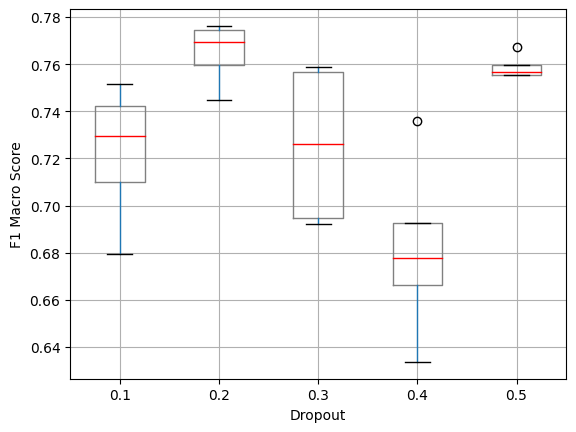

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'eval_dict'
# with columns 'Learning Rate' and 'F1 Macro Score'

# Create a boxplot from the DataFrame
boxplot = pd.DataFrame.from_dict(eval_dict).boxplot(color=dict(boxes='gray', medians='red'))

# Set the x-axis label
plt.xlabel("Dropout")

# Set the y-axis label
plt.ylabel("F1 Macro Score")

# Display the plot
plt.show()

In [ ]:
eval_dict={}
for embedding_size in [50, 100, 500, 1000, 2000]:
  iteration_list=[]
  for iteration in range(1, 5):
    patience = 10  # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
    best_loss = float('inf')  # Initialize the best validation loss
    wait = 0  # Counter for patience


    losses = []
    loss_function = nn.BCELoss()
    #loss_function = nn.CrossEntropyLoss()
    # Instantiate Adadelta optimizer
    model = CNN(0.2, embedding_size, 30)
    optimizer = optim.Adadelta(model.parameters(),
                                  lr=0.2,
                                  weight_decay=10e-3,
                                  rho=0.99)

    model.to(device)
    num_epochs=60


    for epoch in range(num_epochs):
        total_loss = 0
        counter = 0

        for batch in train_loader:
          total_loss = 0
        counter=0
        for batch in train_loader:
            counter=counter+1

            X=batch[0]
            y=batch[1]
            counter=counter+1


            # Prepare input vector
            context_idxs = torch.as_tensor(X, dtype=torch.long, device=device)

            # zero out gradients
            model.zero_grad()

            # run forward pass
            log_probs = model(context_idxs)

            # Compute loss function
            loss = loss_function(log_probs, torch.as_tensor(y, dtype=torch.float, device=device))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()


            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()



        losses.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {total_loss}]')

        # Validation loss calculation (assuming you have a validation_loader)
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_batch in val_loader:
                val_X, val_y = val_batch
                val_context_idxs = torch.as_tensor(val_X, dtype=torch.long, device=device)
                val_log_probs = model(val_context_idxs)
                val_loss += loss_function(val_log_probs, torch.as_tensor(val_y, dtype=torch.float, device=device)).item()
            val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
            break


    import numpy as np
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Start evaluation phase
    with torch.no_grad():
      for batch in test_loader:
        X = batch[0]
        y = batch[1]
        y_pred = model(X.to(torch.int64))
        predictions += list(y_pred.cpu().numpy())

    # Convert 'predictions' to a numpy array
    predictions = np.array(predictions)



    from sklearn.metrics import accuracy_score, f1_score

    # Convert y_true to float
    y_true = df_test['y'].astype(float)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, predictions.round())

    # Calculate F1 score
    f1 = f1_score(y_true, predictions.round(), average='macro')

    print(f"Embedding Size: {embedding_size}")

    print(f"Accurancy on Test Dataset: {accuracy}")

    print(f"F1-score on Test Dataset: {f1}")

    iteration_list.append(f1)

  eval_dict[embedding_size]=iteration_list

Epoch [10/60], loss: 52.14270696043968]
Epoch [20/60], loss: 4.803572928532958]
Epoch [30/60], loss: 2.893840204924345]
Early stopping after 34 epochs with no improvement in validation loss.
Embedding Size: 50
Accurancy on Test Dataset: 0.7827510917030568
F1-score on Test Dataset: 0.7587352008841417
Epoch [10/60], loss: 61.49410155415535]
Epoch [20/60], loss: 7.379272384569049]
Early stopping after 23 epochs with no improvement in validation loss.
Embedding Size: 50
Accurancy on Test Dataset: 0.7347161572052402
F1-score on Test Dataset: 0.677075006492216
Epoch [10/60], loss: 59.200121968984604]
Epoch [20/60], loss: 4.974164193496108]
Early stopping after 25 epochs with no improvement in validation loss.
Embedding Size: 50
Accurancy on Test Dataset: 0.7947598253275109
F1-score on Test Dataset: 0.7711886476575165
Epoch [10/60], loss: 65.57504862546921]
Epoch [20/60], loss: 10.780474739149213]
Early stopping after 22 epochs with no improvement in validation loss.
Embedding Size: 50
Accura

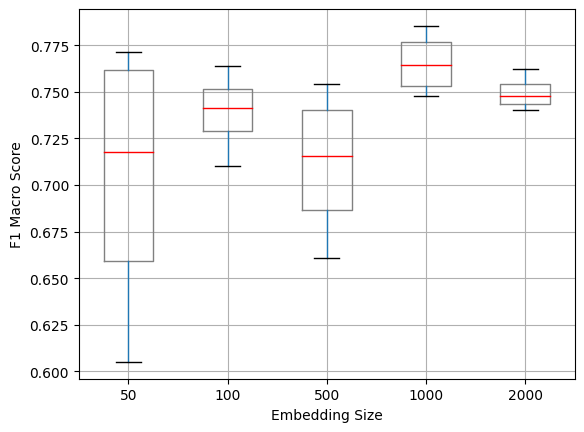

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'eval_dict'
# with columns 'Learning Rate' and 'F1 Macro Score'

# Create a boxplot from the DataFrame
boxplot = pd.DataFrame.from_dict(eval_dict).boxplot(color=dict(boxes='gray', medians='red'))

# Set the x-axis label
plt.xlabel("Embedding Size")

# Set the y-axis label
plt.ylabel("F1 Macro Score")

# Display the plot
plt.show()

In [ ]:
eval_dict={}
for out_size in [30, 60, 100, 200]:
  iteration_list=[]
  for iteration in range(1, 5):
    patience = 10  # Number of epochs to wait for improvement
    min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
    best_loss = float('inf')  # Initialize the best validation loss
    wait = 0  # Counter for patience


    losses = []
    loss_function = nn.BCELoss()
    #loss_function = nn.CrossEntropyLoss()
    # Instantiate Adadelta optimizer
    model = CNN(0.3, 1000, out_size)
    optimizer = optim.Adadelta(model.parameters(),
                                  lr=0.2,
                                  weight_decay=10e-3,
                                  rho=0.99)

    model.to(device)
    num_epochs=60


    for epoch in range(num_epochs):
        total_loss = 0
        counter = 0

        for batch in train_loader:
          total_loss = 0
        counter=0
        for batch in train_loader:
            counter=counter+1

            X=batch[0]
            y=batch[1]
            counter=counter+1


            # Prepare input vector
            context_idxs = torch.as_tensor(X, dtype=torch.long, device=device)

            # zero out gradients
            model.zero_grad()

            # run forward pass
            log_probs = model(context_idxs)

            # Compute loss function
            loss = loss_function(log_probs, torch.as_tensor(y, dtype=torch.float, device=device))

            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()


            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()



        losses.append(total_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {total_loss}]')

        # Validation loss calculation (assuming you have a validation_loader)
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_batch in val_loader:
                val_X, val_y = val_batch
                val_context_idxs = torch.as_tensor(val_X, dtype=torch.long, device=device)
                val_log_probs = model(val_context_idxs)
                val_loss += loss_function(val_log_probs, torch.as_tensor(val_y, dtype=torch.float, device=device)).item()
            val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
            break


    import numpy as np
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Start evaluation phase
    with torch.no_grad():
      for batch in test_loader:
        X = batch[0]
        y = batch[1]
        y_pred = model(X.to(torch.int64))
        predictions += list(y_pred.cpu().numpy())

    # Convert 'predictions' to a numpy array
    predictions = np.array(predictions)



    from sklearn.metrics import accuracy_score, f1_score

    # Convert y_true to float
    y_true = df_test['y'].astype(float)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, predictions.round())

    # Calculate F1 score
    f1 = f1_score(y_true, predictions.round(), average='macro')

    print(f"Convolution Output Size: {out_size}")

    print(f"Accurancy on Test Dataset: {accuracy}")

    print(f"F1-score on Test Dataset: {f1}")

    iteration_list.append(f1)

  eval_dict[out_size]=iteration_list

Epoch [10/60], loss: 16.975471537560225]
Early stopping after 19 epochs with no improvement in validation loss.
Convolution Output Size: 30
Accurancy on Test Dataset: 0.7794759825327511
F1-score on Test Dataset: 0.7607922225669665
Epoch [10/60], loss: 10.081096118316054]
Early stopping after 19 epochs with no improvement in validation loss.
Convolution Output Size: 30
Accurancy on Test Dataset: 0.7620087336244541
F1-score on Test Dataset: 0.7289263916943594
Epoch [10/60], loss: 10.012836149893701]
Epoch [20/60], loss: 1.4066413273103535]
Early stopping after 24 epochs with no improvement in validation loss.
Convolution Output Size: 30
Accurancy on Test Dataset: 0.7740174672489083
F1-score on Test Dataset: 0.7454212970608494
Epoch [10/60], loss: 6.147736605256796]
Epoch [20/60], loss: 1.5521024260669947]
Epoch [30/60], loss: 0.9052110961638391]
Early stopping after 36 epochs with no improvement in validation loss.
Convolution Output Size: 30
Accurancy on Test Dataset: 0.7805676855895196

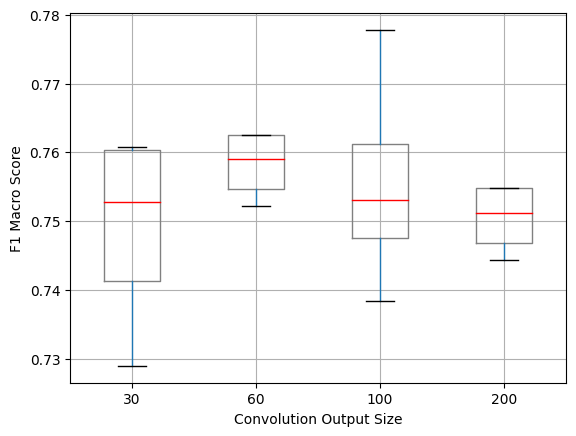

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'eval_dict'
# with columns 'Learning Rate' and 'F1 Macro Score'

# Create a boxplot from the DataFrame
boxplot = pd.DataFrame.from_dict(eval_dict).boxplot(color=dict(boxes='gray', medians='red'))

# Set the x-axis label
plt.xlabel("Convolution Output Size")

# Set the y-axis label
plt.ylabel("F1 Macro Score")

# Display the plot
plt.show()

In [ ]:
pd.DataFrame.from_dict(eval_dict).mean()

30     0.748833
60     0.758229
100    0.755577
200    0.750383
dtype: float64

### Part 2 - Test on second dataset

In [ ]:
#keep anger and joy & tokenize - testset
labels_to_keep=['0','2']


X_test, y_test = [], []
for i in test_text.index:
  X_test.append(test_text.loc[i,'data'])
  y_test.append(test_labels.loc[i,'data'])

X_numeric_test=[]
for i in X_test:
  X_numeric_test.append([word_to_ix[w] for w in i])

df_test=pd.DataFrame(columns=['X','y'])
df_test.X=X_numeric_test
df_test.y=y_test

df_test=df_test[df_test.y.isin(labels_to_keep)].reset_index(drop=True)
df_test.y=df_test['y'].replace('2', '1')


#Keep anger & joy and tokenize - training set
X_train, y_train = [], []
for i in train_text.index:
  X_train.append(train_text.loc[i,'data'])
  y_train.append(train_labels.loc[i,'data'])

X_numeric_train=[]
for i in X_train:
  X_numeric_train.append([word_to_ix[w] for w in i])


df_train=pd.DataFrame(columns=['X','y'])
df_train.X=X_numeric_train
df_train.y=y_train

df_train=df_train[df_train.y.isin(labels_to_keep)].reset_index(drop=True)

df_train.y=df_train['y'].replace('2', '1')


#Keep anger & joy and tokenize - validation set
X_val, y_val = [], []
for i in val_text.index:
  X_val.append(val_text.loc[i,'data'])
  y_val.append(val_labels.loc[i,'data'])

X_numeric_val=[]
for i in X_val:
  X_numeric_val.append([word_to_ix[w] for w in i])


df_val=pd.DataFrame(columns=['X','y'])
df_val.X=X_numeric_val
df_val.y=y_val

df_val=df_val[df_val.y.isin(labels_to_keep)].reset_index(drop=True)
df_val.y=df_val['y'].replace('2', '1')




# Get max no. words per tweet for padding
max_len=[]
max_len.append(df_train['X'].apply(len).max())


max_len.append(df_test['X'].apply(len).max())


max_len.append(df_test['X'].apply(len).max())

max_length=max(max_len)
print(f"maximum number of words per tweet is {max_length}")

maximum number of words per tweet is 23


In [ ]:
#Pad all tweets with zeroes at the end to match the longest tweet in dataset (24 words)
for i in df_test.index:
  while len(df_test.loc[i, 'X']) < max_length:
    df_test.loc[i, 'X'].append(0)

for i in df_train.index:
  while len(df_train.loc[i, 'X']) < max_length:
    df_train.loc[i, 'X'].append(0)


for i in df_val.index:
  while len(df_val.loc[i, 'X']) < max_length:
    df_val.loc[i, 'X'].append(0)

In [ ]:
#Load data to DataLoader

from torch.utils.data import IterableDataset, DataLoader

num_batches=20

X_train=torch.FloatTensor(df_train.X.to_list())

y_train=torch.FloatTensor(df_train.y.astype(float).to_list())

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#Load data to dataloader
class MyDataset(IterableDataset):
    def __init__(self, data_X, data_y):
        assert len(data_X) == len(data_y)
        self.data_X = data_X.to(device)
        self.data_y = data_y.to(device)

    def __len__(self):
        return len(self.data_X)

    def __iter__(self):
        for i in range(len(self.data_X)):
            yield (self.data_X[i], self.data_y[i])

train_set = MyDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=num_batches, drop_last=True)




X_val=torch.FloatTensor(df_val.X.to_list())

y_val=torch.FloatTensor(df_val.y.astype(float).to_list())



val_set = MyDataset(X_val, y_val)
val_loader = DataLoader(val_set, batch_size=num_batches, drop_last=True)



# load test set
X_test=torch.FloatTensor(df_test.X.to_list())

y_test=torch.FloatTensor(df_test.y.astype(float).to_list())


test_set = MyDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=num_batches, drop_last=True)

In [ ]:
import math
class CNN(nn.Module):

   def __init__(self,dropout, embedding_size, out_size):
        super(CNN, self).__init__()

        self.seq_len = max_length
        self.num_words = vocab_size
        self.embedding_size = embedding_size

        self.dropout = nn.Dropout(dropout)


        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4



        self.stride = 1

        # Output size for each convolution
        self.out_size = out_size

        # Embedding layer definition
        self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0, max_norm=5.0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)



         # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, 2)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, 2)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, 2)



        # output layers sized (see here: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
        # simplifies for each conv layer to: embedding_size-(kernel_size-1) since stride=1, padding=0, dillation=1
        #factor 2 in front of second term is due to convolution and padding
        self.output_size=int(0.5*self.out_size*(3*self.embedding_size - 2*(self.kernel_1 + self.kernel_2 + self.kernel_3  - 3)))

        # Batch Norm
        self.batch_norm = nn.BatchNorm1d(self.output_size)

        self.linear = nn.Linear(self.output_size, 1)

        self.output_activation=nn.Sigmoid()
        self.nonlin=nn.ReLU()





   def forward(self, x):


        # Sequence of tokes is filterd through an embedding layer
        x = self.embedding(x)

        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        #print(x1.shape)
        x1 = self.nonlin(x1)
        #print(x1[0])
        x1 = self.pool_1(x1)
        x1=self.dropout(x1)
        #print(x1[0])
        #print('--------------------------')

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = self.nonlin((x2))
        x2 = self.pool_2(x2)
        x2 = self.dropout(x2)


        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = self.nonlin(x3)
        x3 = self.pool_3(x3)
        x3 = self.dropout(x3)



        #print(x1.shape, x2.shape, x3.shape, x4.shape)


        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3), 2)
        #print(union.shape)
        union = union.reshape(union.size(0), -1)
        #print(union.shape)
        #print(self.output_size)

        norm=self.batch_norm(union)

        # The "flattened" vector is passed through a fully connected layer
        out = self.linear(norm).float()
        # Dropout is applied
        out = self.dropout(out)
        # Activation function is applied
        out = self.output_activation(out)

        return out.squeeze()

In [ ]:
eval_dict={}

iteration_list=[]
for iteration in range(1,11):
  patience = 10  # Number of epochs to wait for improvement
  min_delta = 0.001  # Minimum change in validation loss to be considered an improvement
  best_loss = float('inf')  # Initialize the best validation loss
  wait = 0  # Counter for patience


  losses = []
  loss_function = nn.BCELoss()
  #loss_function = nn.CrossEntropyLoss()
  # Instantiate Adadelta optimizer
  model = CNN(0.3, 1000, 60)
  optimizer = optim.Adadelta(model.parameters(),
                                lr=0.2,
                                weight_decay=10e-3,
                                rho=0.99)

  model.to(device)
  num_epochs=60


  for epoch in range(num_epochs):
      total_loss = 0
      counter = 0

      for batch in train_loader:
        total_loss = 0
      counter=0
      for batch in train_loader:
          counter=counter+1

          X=batch[0]
          y=batch[1]
          counter=counter+1


          # Prepare input vector
          context_idxs = torch.as_tensor(X, dtype=torch.long, device=device)

          # zero out gradients
          model.zero_grad()

          # run forward pass
          log_probs = model(context_idxs)

          # Compute loss function
          loss = loss_function(log_probs, torch.as_tensor(y, dtype=torch.float, device=device))

          # Step 5. Do the backward pass and update the gradient
          loss.backward()
          optimizer.step()


          # Get the Python number from a 1-element Tensor by calling tensor.item()
          total_loss += loss.item()



      losses.append(total_loss)

      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {total_loss}]')

      # Validation loss calculation (assuming you have a validation_loader)
      model.eval()
      with torch.no_grad():
          val_loss = 0
          for val_batch in val_loader:
              val_X, val_y = val_batch
              val_context_idxs = torch.as_tensor(val_X, dtype=torch.long, device=device)
              val_log_probs = model(val_context_idxs)
              val_loss += loss_function(val_log_probs, torch.as_tensor(val_y, dtype=torch.float, device=device)).item()
          val_loss /= len(val_loader)

      # Check for early stopping
      if val_loss < best_loss - min_delta:
          best_loss = val_loss
          wait = 0
      else:
          wait += 1

      if wait >= patience:
          print(f'Early stopping after {epoch + 1} epochs with no improvement in validation loss.')
          break


  import numpy as np
  # Set the model in evaluation mode
  model.eval()
  predictions = []

  # Start evaluation phase
  with torch.no_grad():
    for batch in test_loader:
      X = batch[0]
      y = batch[1]

      y_pred = model(X.to(torch.int64))
      predictions += list(y_pred.cpu().numpy())

  # Convert 'predictions' to a numpy array
  predictions = np.array(predictions)



  from sklearn.metrics import accuracy_score, f1_score

  # Convert y_true to float
  y_true = df_test['y'][:-1].astype(float)

  # Calculate accuracy
  accuracy = accuracy_score(y_true, predictions.round())

  # Calculate F1 score
  f1 = f1_score(y_true, predictions.round(), average='macro')



  print(f"Accurancy on Test Dataset: {accuracy}")

  print(f"F1-score on Test Dataset: {f1}")

  iteration_list.append(f1)

  eval_dict['Test']=iteration_list

Epoch [10/60], loss: 20.679281290620565]
Epoch [20/60], loss: 2.164315567119047]
Early stopping after 22 epochs with no improvement in validation loss.
Accurancy on Test Dataset: 0.8338235294117647
F1-score on Test Dataset: 0.6465094882116159
Epoch [10/60], loss: 21.989423360675573]
Epoch [20/60], loss: 1.7004281571134925]
Early stopping after 21 epochs with no improvement in validation loss.
Accurancy on Test Dataset: 0.8117647058823529
F1-score on Test Dataset: 0.6216902240998626
Epoch [10/60], loss: 22.007654029875994]
Epoch [20/60], loss: 1.7711746417917311]
Early stopping after 23 epochs with no improvement in validation loss.
Accurancy on Test Dataset: 0.8308823529411765
F1-score on Test Dataset: 0.6870485314892408
Epoch [10/60], loss: 20.849526032805443]
Epoch [20/60], loss: 1.446398372296244]
Early stopping after 23 epochs with no improvement in validation loss.
Accurancy on Test Dataset: 0.8352941176470589
F1-score on Test Dataset: 0.6744130371586381
Epoch [10/60], loss: 23.06

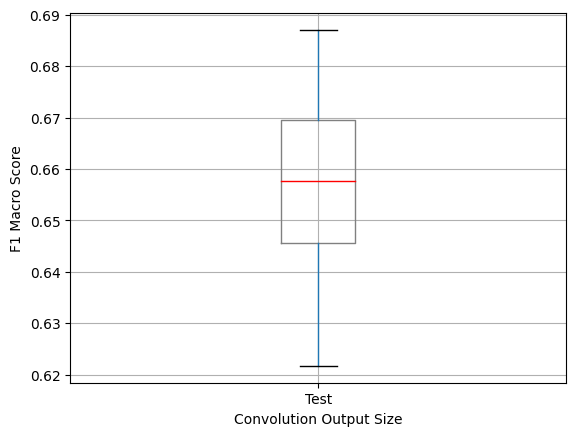

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'eval_dict'
# with columns 'Learning Rate' and 'F1 Macro Score'

# Create a boxplot from the DataFrame
boxplot = pd.DataFrame.from_dict(eval_dict).boxplot(color=dict(boxes='gray', medians='red'))

# Set the x-axis label
plt.xlabel("Convolution Output Size")

# Set the y-axis label
plt.ylabel("F1 Macro Score")

# Display the plot
plt.show()